In [14]:
%load_ext autoreload
%autoreload 2

import sys
import os
current_directory = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_directory, os.pardir)))
import glob
                 
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mayavi import mlab
from mpl_toolkits.mplot3d import Axes3D
from geom_lrr.loader import Loader
from geom_lrr.analyzer import Analyzer, compute_lrr_discrepancy, compute_lrr_discrepancy_arithmetic 
from geom_lrr.analyzer import compute_laplacian_circular_coords, compute_lrr_winding_laplacian
from geom_lrr.plotter import plot_regression, plot_residue_annotations_3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load in LRR-Predict results

In [15]:
res = pd.read_csv("../data/col-0-nlrome.csv", sep="\t")
labels = [s.split("Athaliana_")[1] for s in res["annotation"].values]
starts = [int(s) for s in res["start"].values]
predictions = {}
for l, s in zip(labels, starts):
    l = l.replace("_", ".")
    if not l in predictions:
        predictions[l] = []
    predictions[l].append(s)
for l, p in predictions.items():
    predictions[l] = np.sort(np.array(p, dtype=int))

proteins = set([s.split("/")[-1].split(".pdb")[0] for s in glob.glob("../data/a_thaliana_alpha/*")])
predictions = {key:value for key, value in predictions.items() if key in proteins}

### Compute parallel transport-based winding number and RMS LRR Losses

In [16]:
loader = Loader()
loader.load_batch("../data/a_thaliana_alpha")

Loading PDBs: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:08<00:00, 15.18it/s]


In [17]:
analyzer = Analyzer()
analyzer.load_structures(loader.structures)
analyzer.compute_windings()

Computing windings: 100%|██████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 74.87it/s]


In [18]:
analyzer.compute_regressions()

Computing regressions: 100%|███████████████████████████████████████████████████████████████████████████████████| 127/127 [04:35<00:00,  2.17s/it]


9 Proteins Have An RMS LRR Loss Exceeding 1


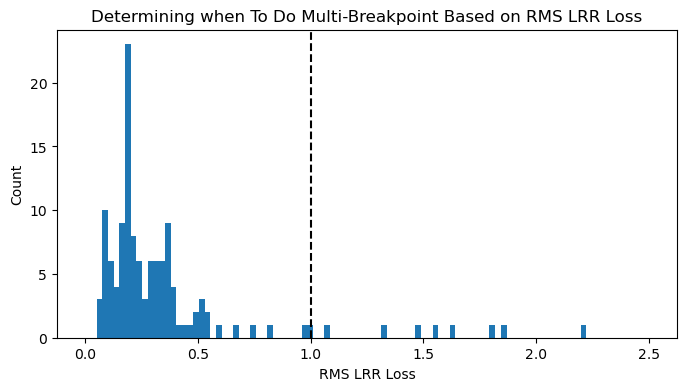

In [19]:
cutoff = 1
stds = np.array(list(analyzer.stds.values()))
plt.figure(figsize=(8, 4))
plt.hist(stds, bins=np.linspace(0, 2.5, 100));
plt.axvline(cutoff, linestyle='--', c='k')
plt.xlabel("RMS LRR Loss")
plt.ylabel("Count")
plt.title("Determining when To Do Multi-Breakpoint Based on RMS LRR Loss")
plt.savefig("RMSLRRLossHist.svg", bbox_inches='tight')
print("{} Proteins Have An RMS LRR Loss Exceeding {}".format(np.sum(stds > cutoff), cutoff))

### Compute Discrepancies with LRR-Predict

In [20]:
analyzer.compute_lrr_windings_laplacian()

Computing Laplacian windings:   0%|                                                                                      | 0/127 [00:00<?, ?it/s]


ModuleNotFoundError: No module named 'gudhi'

In [ ]:
proteins_list = list(proteins)
discrepancies_parallel = np.zeros(len(proteins))
discrepancies_laplace = np.zeros(len(proteins))
for i, p in enumerate(proteins_list):
    pred = predictions[p]
    breakpoints = analyzer.breakpoints[p]
    a = breakpoints[0]
    b = breakpoints[-1]
    discrepancies_parallel[i] = compute_lrr_discrepancy(analyzer.windings[p], pred, a, b)
    discrepancies_laplace[i] = compute_lrr_discrepancy(analyzer.lwindings[p], pred, a, b)

## Validation Set

Compare results on validation set using parallel transport and Laplacian circular coordinates


### Load in validation set ground truth

In [ ]:
ground_truth = {}
for [p, t, seq] in pd.read_csv("../data/LRRPredictor_validation_groundTruth.csv").values:
    if t == "LRR motifs":
        locs = []
        for i, c in enumerate(seq):
            if c != '-':
                locs.append(i)
        ground_truth[p] = np.array(locs, dtype=int)

### Compute both types of winding numbers and RMS LRR Losses

In [ ]:
loader = Loader()
loader.load_batch("../data/validation_pdb")
analyzerv = Analyzer()
analyzerv.load_structures(loader.structures)
analyzerv.compute_windings()
analyzerv.compute_regressions()


In [ ]:
analyzerv.compute_lrr_windings_laplacian()

In [ ]:
import seaborn as sns

proteins_list = list(ground_truth.keys())
discrepancies_parallel_validation = np.zeros(len(proteins_list))
discrepancies_laplace_validation = np.zeros(len(proteins_list))
for i, p in enumerate(proteins_list):
    gt = ground_truth[p]
    found = False
    for p2 in analyzerv.breakpoints.keys():
        if p in p2:
            p = p2
            found = True
    if found:
        breakpoints = analyzerv.breakpoints[p]
        a = breakpoints[0]
        b = breakpoints[-1]
        discrepancies_parallel_validation[i] = compute_lrr_discrepancy(analyzerv.windings[p], gt, a, b)
        discrepancies_laplace_validation[i] = compute_lrr_discrepancy(analyzerv.lwindings[p], gt, a, b)
    else:
        print("Did not find", p)

bins = np.linspace(0, 2.5, 50)
data = {"Parallel Transport\nValidation":discrepancies_parallel_validation, "Laplacian\nValidation":discrepancies_laplace_validation, 
        "Parallel Transport\nLRR Predict":np.pad(discrepancies_parallel, (0, 178-127), 'constant', constant_values=(0, np.inf)),
        "Laplacian\nLRR Predict":np.pad(discrepancies_laplace, (0, 178-127), 'constant', constant_values=(0, np.inf))}
plt.figure(figsize=(6, 3))
sns.boxplot(pd.DataFrame(data=data))
plt.title("Evaluation Discrepancies")
plt.yscale("log")
plt.ylabel("Discrepancy")
plt.savefig("Evaluation.svg")